<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:60px; font-weight:bold;">Karaoke Classificatie</div>
</div>
<br>
<p>-- Omschrijving Opdracht --<p>

-- Namen/Platformen --

-- Inhoudsopgave? --

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Inladen van libaries en data</div>
</div>
<br>
<p>Om de data te kunnen onderzoeken is het belangrijk dat alle nodige libaries ervoor worden geinstalleerd. Naast de standaard libaries is er ook een `.py` bestand aanwezig in de GitHub, in dit bestand staan diverse functies die zijn ontwikkelt voor gebruik in het notebook.<p>

In [87]:
# Inladen van alle dependecies en functies in functies.py
from functies import *
from datetime import datetime

# Importeren van nodige libaries bij inladen
from pathlib import Path

# Importeren DL
import tensorflow as tf
from tensorflow import keras

Ook zijn er bepaalde standaard opties die helpen in het notebook. Zo kan er een seed worden vastgezet, zodat het project kan worden gereproduceerd.

In [2]:
# Aanmaken van een SEED 
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

Nu de nodige libaries zijn ingeladen is het tijd om de csv bestanden in te laden.

In [3]:
# Inladen van de train en test dataset
train_data = pd.read_csv("train.csv", sep=",")
test_data = pd.read_csv("test.csv", sep=",")

# Tonen van de eerste vijf regels
display(train_data.head(), test_data.head())

,filename,lyrics,genre
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues


,filename,lyrics
0,test.00000.wav,[Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
1,test.00001.wav,[Verse 1]\nThere's an old Kodak camera in my d...
2,test.00002.wav,"[Intro]\nSo curious, so curious\n\n[Verse 1]\n..."
3,test.00003.wav,[Intro]\nWhere do I take this pain of mine\nI ...
4,test.00004.wav,"[Verse 1]\nBaby's into runnin' around, hangin'..."


Naast het inladen van de csv bestanden zijn er ook nog audio fragmenten die moeten worden ingeladen.

In [55]:
# Geven van de directories
train_dir = "Train"
test_dir = "Test"

# Aanmaken van de train en validation datasets
train_ds, val_ds = keras.utils.audio_dataset_from_directory(
    directory=train_dir,
    batch_size=4,
    validation_split=0.2,
    seed=SEED,
    output_sequence_length=30*22050,
    subset='both'
    )

# Aanmaken van de test dataset
test_ds = keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=1,
    seed=SEED,
    label_mode=None,
    output_sequence_length=30*22050
    )

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.
Found 129 files.


Nu alle bestanden zijn ingelezen is het tijd om door te gaan naar het EDA.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Exploratory Data Analysis</div>
</div>
<br>
<p>-- Opening EDA en eerste stappen --<p>

In [85]:
# Tonen van de class names
label_names = np.array(train_ds.class_names)

print("label names:", label_names)

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 661500, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
test_ds.element_spec

TensorSpec(shape=(None, 661500, None), dtype=tf.float32, name=None)

In [8]:
def squeeze(audio, labels=None):
    audio = tf.squeeze(audio, axis=-1)
    if labels is None:
        return audio
    else:
        return audio, labels

train_audio = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_audio = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_audio = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
train_audio.element_spec

(TensorSpec(shape=(None, 661500), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
test_audio.element_spec

TensorSpec(shape=(None, 661500), dtype=tf.float32, name=None)

In [11]:
train_ads = train_audio.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ads = val_audio.cache().prefetch(tf.data.AUTOTUNE)
test_ads = test_audio.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [30]:
def make_spec_ds(ds, label=True):
    if label is True:
      return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
        )
    if label is False:
      return ds.map(
        map_func=lambda audio: (get_spectrogram(audio)),
        num_parallel_calls=tf.data.AUTOTUNE
        )

In [31]:
train_spectrogram_ds = make_spec_ds(train_ads)
val_spectrogram_ds = make_spec_ds(val_ads)
test_spectrogram_ds = make_spec_ds(test_ads, label=False)

In [32]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [33]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=13, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [34]:
def make_MFCC_ds(ds, label=True):
    if label is True:
      return ds.map(
        map_func=lambda audio,label: (spectrogram_to_mfcc(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
        )
    if label is False:
      return ds.map(
        map_func=lambda audio: (spectrogram_to_mfcc(audio)),
        num_parallel_calls=tf.data.AUTOTUNE
        )

In [35]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)
test_MFCC_ds = make_MFCC_ds(test_spectrogram_ds, label=False)

In [36]:
train_MFCC_ds = train_MFCC_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)

Doordat alle data nu onderzocht en aangepast is, kan er worden gewerkt aan de modellen.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Modelleren</div>
</div>
<br>
<p>-- Opening statement en voorbereiden data indien verder nodig --<p>
<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Long Short-Term Memory model, audiofragmenten</div>
</div>
<br>
<p> -- uitleg en opening --<p>

In [28]:
# Opstellen van model met Sequential API
model = keras.Sequential([
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(16),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='softmax')
])

# Compile het model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Toon model architectuur
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=10,
    batch_size=32
)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.1429 - loss: 2.0723 - val_accuracy: 0.2243 - val_loss: 2.0126
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.2854 - loss: 1.9605 - val_accuracy: 0.2991 - val_loss: 1.9003
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.2861 - loss: 1.8329 - val_accuracy: 0.2991 - val_loss: 1.8150
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.3214 - loss: 1.7451 - val_accuracy: 0.2991 - val_loss: 1.8316
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3199 - loss: 1.7303 - val_accuracy: 0.3084 - val_loss: 1.7622
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.3413 - loss: 1.6505 - val_accuracy: 0.3458 - val_loss: 1.7412
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.3698 - loss: 1.6238 - val_accuracy: 0.3925 - val_loss: 1.6754
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.4189 - loss: 1.5438 - val_accu

Text(0, 0.5, 'Accuracy [%]')

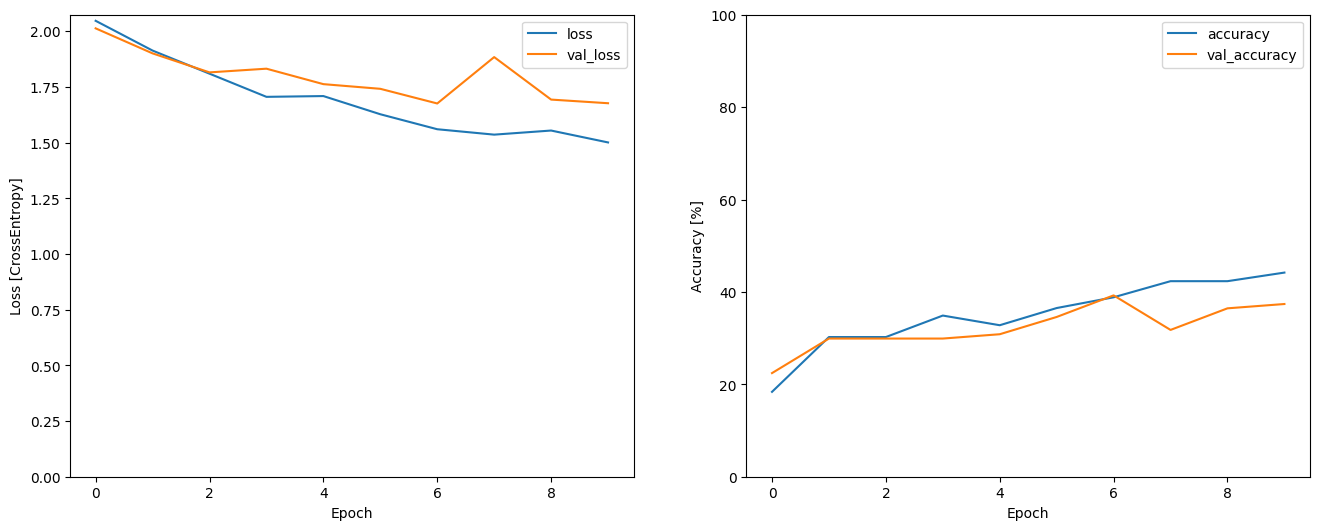

In [38]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [99]:
kaggle_csv(model=model, input_=test_MFCC_ds, suffix="test")

129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step
voorspelling_test_0404003518.csv has been saved!


<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Long Short-Term Memory model, Teksten</div>
</div>
<br>
<p> -- uitleg en opening --<p>